# Retrieving data on BART ridership

In [1]:
from pybart.api import BART # for interacting w/ BART API
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from postgres_login import secret # my postgreSQL password
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import os
import sys
import io
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# import custom scripts
import pitt_line_stations

## Set up data base
If we haven't already, set up the postgres database that will house the data

In [3]:
# Define a database name 
dbname = 'bart_db'
username = 'bkhurley' # change this to your username

In [7]:
# db connection
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://bkhurley@localhost/bart_db


In [8]:
# create the database if it doesn't exist
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


## Get the data 
Retrieve the BART data and store it in the 'bart_db' database

#### Define some functions

In [4]:
# load and append the data into a pandas dataframe
def load_bart_orig_dest_data(urls):
    # generate list of dataframes from the provided csv urls
    data_ls = [pd.read_csv(d, header=None) for d in urls]
    # return single concatinated dataframe
    data = pd.concat(data_ls)
    return data    

#### Retrieve BART data

In [6]:
# the data come from CSVs provided on the web yearly by BART
orig_dest_urls = ['http://64.111.127.166/origin-destination/date-hour-soo-dest-2011.csv.gz']#,

# lets just restrict to 2011 while getting the MVP going

#        'http://64.111.127.166/origin-destination/date-hour-soo-dest-2012.csv.gz',
#        'http://64.111.127.166/origin-destination/date-hour-soo-dest-2013.csv.gz',
#        'http://64.111.127.166/origin-destination/date-hour-soo-dest-2014.csv.gz',
#        'http://64.111.127.166/origin-destination/date-hour-soo-dest-2015.csv.gz',
#        'http://64.111.127.166/origin-destination/date-hour-soo-dest-2016.csv.gz',
#        'http://64.111.127.166/origin-destination/date-hour-soo-dest-2017.csv.gz']

In [7]:
# get the data and put them into a dataframe
bart_dest_org_df = load_bart_orig_dest_data(orig_dest_urls)

In [8]:
# check out the structure of the raw data
bart_dest_org_df.head()

,0,1,2,3,4
0,2011-01-01,0,12TH,12TH,1
1,2011-01-01,0,12TH,16TH,1
2,2011-01-01,0,12TH,24TH,3
3,2011-01-01,0,12TH,ASHB,2
4,2011-01-01,0,12TH,BAYF,5


### Initial cleaning

In [9]:
# rename columns to something informative
bart_dest_org_df.rename(columns={0: 'date', 1: 'hour', 2: 'orig', 3: 'dest', 4: 'trips_per_hr'},
         inplace=True)

In [10]:
bart_dest_org_df.head()

,date,hour,orig,dest,trips_per_hr
0,2011-01-01,0,12TH,12TH,1
1,2011-01-01,0,12TH,16TH,1
2,2011-01-01,0,12TH,24TH,3
3,2011-01-01,0,12TH,ASHB,2
4,2011-01-01,0,12TH,BAYF,5


### Get route info 

For now, let's just look at trips originating from or terminating at stations on the PITT line. This is the busiest BART line.

Can get ordered list of stations on the PITT line from the BART's [route info API](https://api.bart.gov/docs/route/routeinfo.aspx)

In [11]:
# access BART API w/ public key
bart = BART(json_format=True)

In [12]:
# request ordered station names for the PITT-MLBR route
route_info_root = bart.route.routeinfo(route=1)
stations = route_info_root['routes']['route']['config']['station']
print(stations)

['PITT', 'NCON', 'CONC', 'PHIL', 'WCRK', 'LAFY', 'ORIN', 'ROCK', 'MCAR', '19TH', '12TH', 'WOAK', 'EMBR', 'MONT', 'POWL', 'CIVC', '16TH', '24TH', 'GLEN', 'BALB', 'DALY', 'COLM', 'SSAN', 'SBRN', 'SFIA', 'MLBR']


#### Use the above station list to filter for trips that start and end on the PITT line

In [13]:
pitt_df = bart_dest_org_df.loc[bart_dest_org_df['orig'].isin(stations) &
                               bart_dest_org_df['dest'].isin(stations)]
# Some trips originate and terminate at the same station. 
# Going to remove for now until I figure out what's going on.
pitt_df.drop(pitt_df[pitt_df['orig'] == pitt_df['dest']].index, inplace=True)
pitt_df.reset_index(drop=True, inplace=True) # renumber indices after dropping rows

#### Differentiate northbound from southbound

In [14]:
def get_route_dir(df, stations):
    '''
    Use the ordered list of stations on the PITT line to determine direction 
    '''
    for station in stations:
        station_idx = stations.index(station)
        # label southbound trips, unless already at end of line
        if not station == 'MLBR':
            sb_stations = stations[(station_idx+1):]
            df.loc[((df['orig'] == station) & 
                    df['dest'].isin(sb_stations)), 'direction'] = 'southbound'
        # label northbound trips, unless at beginning of line
        if not station == 'PITT':
            nb_stations = stations[:(station_idx)]
            df.loc[((df['orig'] == station) &
                    df['dest'].isin(nb_stations)), 'direction'] = 'northbound'
    return df

In [15]:
# determine & label nbound/sbound direction of trips
pitt_df['direction'] = '' # initialize column
pitt_df = get_route_dir(pitt_df, stations)

Check that the direction labels are correct

In [16]:
pitt_df.loc[pitt_df['direction'] == 'northbound'].head()

,date,hour,orig,dest,trips_per_hr,direction
3,2011-01-01,0,12TH,CONC,2,northbound
6,2011-01-01,0,12TH,MCAR,12,northbound
9,2011-01-01,0,12TH,PHIL,1,northbound
10,2011-01-01,0,12TH,PITT,1,northbound
12,2011-01-01,0,12TH,ROCK,1,northbound


In [17]:
pitt_df.loc[pitt_df['direction'] == 'southbound'].head()

,date,hour,orig,dest,trips_per_hr,direction
0,2011-01-01,0,12TH,16TH,1,southbound
1,2011-01-01,0,12TH,24TH,3,southbound
2,2011-01-01,0,12TH,CIVC,3,southbound
4,2011-01-01,0,12TH,DALY,1,southbound
5,2011-01-01,0,12TH,EMBR,4,southbound


### Calculate rider volume 

In [85]:
def calc_rider_sums(df, col, trip_label):
    '''
    Calculate total trips per date-hour-direction-station combo.
    Rename trip count using trip_label (should be 'entries' or 'exits')
    '''
    df = pitt_df.groupby(['date', 'hour', 'direction', col]).sum()
    df.reset_index(inplace=True)
    df.rename(columns={col: 'station', 'trips_per_hr': trip_label}, inplace=True)
    return df

In [86]:
# calculate entry sums per date-hour-direction-station
enter_df = calc_rider_sums(pitt_df, 'orig', 'entries')
# calculate exits sums per date-hour-direction-station
exit_df = calc_rider_sums(pitt_df, 'dest', 'exits')

In [87]:
# merge enter & exit dfs
enter_exit_df = pd.merge(enter_df, exit_df)

In [91]:
enter_exit_df.head(30)

,date,hour,direction,station,entries,exits
0,2011-01-01,0,northbound,12TH,18,102
1,2011-01-01,0,northbound,16TH,168,37
2,2011-01-01,0,northbound,19TH,19,91
3,2011-01-01,0,northbound,24TH,116,32
4,2011-01-01,0,northbound,BALB,79,5
5,2011-01-01,0,northbound,CIVC,115,96
6,2011-01-01,0,northbound,COLM,24,2
7,2011-01-01,0,northbound,CONC,2,68
8,2011-01-01,0,northbound,DALY,55,8
9,2011-01-01,0,northbound,EMBR,212,151


Would be a more accurate index of volume if I could track the number of entries and exits going up or down the line, but won't worry about that for now.

In [32]:
# # southbound rider volume when not dealing with first or last station
# #rider_volume = sum(<trips_per_hr w/ origin @ this station>) - sum(<trips_per_hr w/ dest @ this station>)
# station = 'NCON'
# rider_volume = (sum(test_data.loc[test_data['orig'] == station, 'trips_per_hr']) -
#                 sum(test_data.loc[test_data['dest'] == station, 'trips_per_hr']))
# print(rider_volume)

377


#### Generate some temporal features from the date

In [92]:
# transform the dates to pd datetime objects
enter_exit_df['date'] = pd.to_datetime(enter_exit_df['date'])

In [93]:
# generate weekday and month features
enter_exit_df['day'] = enter_exit_df['date'].dt.weekday_name
enter_exit_df['month'] = enter_exit_df['date'].dt.month

In [95]:
enter_exit_df.head(10)

,date,hour,direction,station,entries,exits,day,month
0,2011-01-01,0,northbound,12TH,18,102,Saturday,1
1,2011-01-01,0,northbound,16TH,168,37,Saturday,1
2,2011-01-01,0,northbound,19TH,19,91,Saturday,1
3,2011-01-01,0,northbound,24TH,116,32,Saturday,1
4,2011-01-01,0,northbound,BALB,79,5,Saturday,1
5,2011-01-01,0,northbound,CIVC,115,96,Saturday,1
6,2011-01-01,0,northbound,COLM,24,2,Saturday,1
7,2011-01-01,0,northbound,CONC,2,68,Saturday,1
8,2011-01-01,0,northbound,DALY,55,8,Saturday,1
9,2011-01-01,0,northbound,EMBR,212,151,Saturday,1


### Some early exploratory plots
Generating some plots on entry numbers. Will not deal with exits until I get a handle on volume calculation.

In [100]:
bart_entry_df = enter_exit_df.drop(labels='exits', axis=1)
bart_entry_df.head()

,date,hour,direction,station,entries,day,month
0,2011-01-01,0,northbound,12TH,18,Saturday,1
1,2011-01-01,0,northbound,16TH,168,Saturday,1
2,2011-01-01,0,northbound,19TH,19,Saturday,1
3,2011-01-01,0,northbound,24TH,116,Saturday,1
4,2011-01-01,0,northbound,BALB,79,Saturday,1


In [145]:
#rowdicts = [] 
#for l, d in bart_entry_df.groupby("hour station direction".split()):
#    d = {"hour": l[0], "station": l[1], "direction": l[2]}
#    rowdicts.append(d)                               
#
#df2 = pd.DataFrame.from_dict(rowdicts)
grouped_df = bart_entry_df.groupby(['hour', 'station', 'direction']).mean()
grouped_df.reset_index(inplace=True)
grouped_df.drop(labels='month', axis=1, inplace=True)

In [146]:
grouped_df.head()

,hour,station,direction,entries
0,0,12TH,northbound,8.675000
1,0,12TH,southbound,21.572271
2,0,16TH,northbound,89.052486
3,0,16TH,southbound,47.867403
4,0,19TH,northbound,13.262570


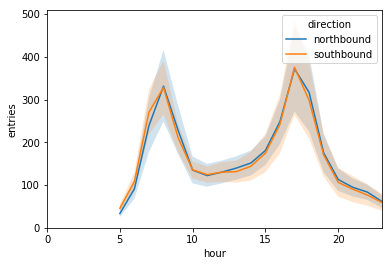

In [147]:
sns.tsplot(data=grouped_df, time="hour", unit='station', value="entries", condition="direction")

In [153]:
# filter for the Mcarthur station
df_mcar = bart_entry_df.loc[bart_entry_df['station']=='MCAR', :]

# avg by station by hour, day, month
mcar_mean = df_mcar.groupby(by=['station', 'day', 'hour']).mean()['entries']
mcar_mean.fillna(value=0, inplace=True)

mcar_mean.head(100)

station  day       hour
MCAR     Friday    0        14.480000
                   1         2.500000
                   4        10.291667
                   5        29.232323
                   6        88.019231
                   7       254.759615
                   8       389.990385
                   9       304.333333
                   10      169.872549
                   11      125.303922
                   12      116.303922
                   13      107.852941
                   14      105.931373
                   15      115.862745
                   16      154.647059
                   17      224.656863
                   18      191.372549
                   19      134.784314
                   20       81.686275
                   21       63.911765
                   22       54.382353
                   23       41.372549
         Monday    0        11.434343
                   1         2.000000
                   4        12.000000
                   5      

Do some pivots to get a glimpse of temporal trends

In [150]:
day_hour_avg = df_mcar.groupby(by=['day', 'hour']).mean()['entries'].unstack()
day_hour_avg.fillna(value=0, inplace=True)
day_hour_avg.head(10)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Friday,14.480000,2.50,0.0,0.0,10.291667,29.232323,88.019231,254.759615,389.990385,304.333333,...,105.931373,115.862745,154.647059,224.656863,191.372549,134.784314,81.686275,63.911765,54.382353,41.372549
Monday,11.434343,2.00,0.0,0.0,12.000000,29.923077,88.505155,269.122449,397.009615,293.951923,...,90.721154,96.990385,133.644231,202.009615,175.423077,92.615385,52.509615,41.990385,35.153846,22.990385
Saturday,27.019608,20.75,35.0,17.5,0.000000,0.000000,15.750000,38.272727,59.480392,87.803922,...,119.500000,102.539216,98.803922,102.480392,90.441176,91.480392,73.029412,59.980392,53.519608,40.480392
Sunday,26.147059,1.00,0.0,0.0,0.000000,0.000000,220.000000,149.500000,33.098039,58.186275,...,95.147059,78.823529,67.343137,65.392157,61.578431,51.823529,42.480392,39.225490,32.960784,22.921569
Thursday,13.845361,0.00,0.0,0.0,13.240000,32.039216,99.960784,295.029412,439.615385,333.730769,...,99.028846,105.740385,146.086538,238.432692,206.173077,113.250000,66.865385,53.336538,46.471154,28.480769
Tuesday,11.294737,0.00,0.0,0.0,12.666667,31.165049,99.625000,299.576923,455.355769,337.067308,...,92.942308,100.826923,146.894231,230.528846,204.567308,105.894231,58.278846,49.980769,41.673077,25.711538
Wednesday,13.473684,4.00,0.0,0.0,12.387755,31.990291,98.250000,294.807692,470.211538,334.346154,...,97.423077,104.884615,148.586538,235.125000,203.326923,109.384615,60.451923,51.538462,43.576923,27.961538


Text(0.5,1,'Avg # entries at MacArthur station')

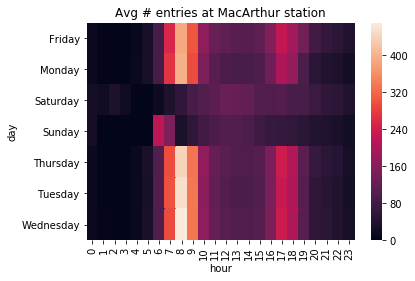

In [151]:
# plot heat map of the days and hours with most rides
sns.heatmap(day_hour_avg)
plt.title('Avg # entries at MacArthur station')

Might want to investigate the 6am blip on Sunday. Seems like a weird time to have a ridership spike.

### Insert BART trip data into database

In [31]:
# #conn = engine.raw_connection()
# # connect to postgres
# conn = psycopg2.connect(database='bart_db', user='postgres', password=secret)
# # retrieve the cursor
# cur = conn.cursor()

In [ ]:
# f = io.StringIO()
# df_pitt.to_csv(f, index=False, header=False)  # removed header
# f.seek(0)  # move position to beginning of file before reading
# cursor = conn.cursor()
# cursor.execute(
#     'CREATE TABLE IF NOT EXISTS orig_dest (date date PRIMARY KEY, hour integer, orig varchar, dest varchar, trips_per_hr integer, day varchar, month integer); COMMIT; '
# )
# cursor.copy_from(f, 'orig_dest', columns=(
#     'date', 'hour', 'orig', 'dest', 'trips_per_hr', 'day', 'month'), 
#                  sep=',')
# cursor.execute("SELECT * FROM orig_dest;")
# a = cursor.fetchall()
# print(a)
# cursor.close()

In [30]:
# cursor.close()

In [ ]:
## insert data into database in chunks
#size = 100000
#for i in round(len(df_pitt['trips_per_hr'])/size):
#   
#df_pitt.to_sql('orig_dest', engine, if_exists='replace')

## Scrape weather data covering the relevant time

In [ ]:
# features to extract
wu_features = ['time_stamp', 'mean_temperature', 'max_temperature', 'min_temperature', 
            'precipitation', 'wind_speed', 'max_wind_speed']

# create 'weatherhistory_raw' table if it doesn't already exist
query = '''
    CREATE TABLE IF NOT EXISTS weatherhistory (
        time_stamp date PRIMARY KEY
        , mean_temperature integer 
        , max_temperature integer 
        , min_temperature integer 
        , precipitation float 
        , wind_speed integer
        , max_wind_speed integer 
    );
        '''
cur.execute(query)
tbl_name = 'weatherhistory'

Define some functions for scraping tasks

In [251]:
# function to return desired table value from url
def get_tbl_value(url, feature):
    # get html tree from page content
    page = requests.get(url)
    tree = html.fromstring(page.content)
    # get column values associated with this feature
    row_data = tree.xpath(
        "//tr[contains(., '%s')]//td//" % feature +
        "span[@class='wx-value']//text()")
    # deal with missing or anomalous data
    if not row_data:
        tbl_val = 'NULL'
    elif row_data[0] in ['', '-']:
        tbl_val = 'NULL'
    elif row_data[0] == 'T': 
        # WU uses T to denote trace of participation. 
        # I will treat that as 0.0 inches
        tbl_val = 0.0
    else:
        # convert str to numerical value
        tbl_val = float(row_data[0])                
    return tbl_val

# function to build timestamp
def make_timestamp(m, d, y):
    # Format month
    if len(str(m)) < 2:
        mStamp = '0' + str(m)
    else:
        mStamp = str(m)
    # Format day
    if len(str(d)) < 2:
        dStamp = '0' + str(d)
    else:
        dStamp = str(d)
    # Build timestamp
    time_stamp = '%s-%s-%s' % (str(y), mStamp, dStamp)
    return time_stamp

### Iteratively scrape weather history pages and store data in database
Iterate through Weather Underground's weather history page for each day within the date range (2006-2017). I use `lxml` library combined with XPath syntax to parse the Weather Undergound XML tables and find the weather values of interest. 

As each day of weather history is scraped, the data are interatively inserted into the postgreSQL table `weatherhistory_raw`

In [252]:
## define the critical rows that we want from the table weather history page
wu_rows = ['timestamp','Mean Temperature','Max Temperature','Min Temperature',
            'Precipitation','Wind Speed','Max Wind Speed']

# Iterate through year, month, and day
for y in range(20011, 2017):
    for m in range(1, 13):
        for d in range(1, 32):
            # new row array for each day
            row_array = []
            
            # Check if leap year
            if y%400 == 0:
                leap = True
            elif y%100 == 0:
                leap = False
            elif y%4 == 0:
                leap = True
            else:
                leap = False
            # Check if already gone through month
            if (m == 2 and leap and d > 29):
                continue
            elif (m == 2 and d > 28):
                continue
            elif (m in [4, 6, 9, 11] and d > 30):
                continue
            
            # Build timestamp
            timestamp = make_timestamp(m=m, d=d, y=y)
        
            # Check if record exists in table. If not, get the data
            cur.execute(
                "SELECT exists (SELECT 1 FROM weatherhistory_raw " +
                "WHERE time_stamp = '%s' LIMIT 1);" % timestamp)
            entry_exists = cur.fetchall()[0]
            if not entry_exists[0]:
                row_array.append("to_date('%s', 'YYYY-MM-DD')" % timestamp)
                # Generate weather history url for this date
                url = ("https://www.wunderground.com/history/airport/KCCR/" +
                       str(y)+ "/" + str(m) + "/" + str(d) + "/DailyHistory.html")
                # Iterate through each desired weather feature and 
                # find corresponding value from weather history XML 
                # table
                for ifeat in range(1, (len(wu_rows))):
                    row_array.append(get_tbl_value(url=url, feature=wu_rows[ifeat]))
                # insert row into weatherhistory_raw table
                insert_str = ("INSERT into weatherhistory_raw " +
                              "(%s, %s, %s, %s, %s, %s, %s) " % 
                              tuple(wu_features))
                value_str = ("VALUES (%s, %s, %s, %s, %s, %s, %s)" %
                            tuple(row_array))
                query_str = insert_str + value_str
                cur.execute(query_str)

        # update status as we work through each month/year
        sys.stdout.write('Scraped weather records for Month: %d, Year: %d\n' % (m, y))

# Done getting data!
sys.stdout.write('\n\nFinished scraping weather data! ' +
                 'Data written to database table: %s\n' % 
                 tbl_name)

Scraped weather records for Month: 1, Year: 2006
Scraped weather records for Month: 2, Year: 2006
Scraped weather records for Month: 3, Year: 2006
Scraped weather records for Month: 4, Year: 2006
Scraped weather records for Month: 5, Year: 2006
Scraped weather records for Month: 6, Year: 2006
Scraped weather records for Month: 7, Year: 2006
Scraped weather records for Month: 8, Year: 2006
Scraped weather records for Month: 9, Year: 2006
Scraped weather records for Month: 10, Year: 2006
Scraped weather records for Month: 11, Year: 2006
Scraped weather records for Month: 12, Year: 2006
Scraped weather records for Month: 1, Year: 2007
Scraped weather records for Month: 2, Year: 2007
Scraped weather records for Month: 3, Year: 2007
Scraped weather records for Month: 4, Year: 2007
Scraped weather records for Month: 5, Year: 2007
Scraped weather records for Month: 6, Year: 2007
Scraped weather records for Month: 7, Year: 2007
Scraped weather records for Month: 8, Year: 2007
Scraped weather r

In [ ]:
# commit database changes and close connection
conn.commit()
conn.close()